In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# -----------------
# 1. Oil Interpolator
# -----------------
class OilInterpolator(BaseEstimator, TransformerMixin):
    def __init__(self, train_dates=None):
        self.train_dates = train_dates
        self.oil_filled_ = None

    def fit(self, X, y=None):
        oil = X.copy()
        oil['date'] = pd.to_datetime(oil['date'])

        # Eğer train_dates verilmişse, ona göre tarih aralığını genişlet
        if self.train_dates is not None:
            min_date = self.train_dates['date'].min()
            max_date = self.train_dates['date'].max()
            full_date_range = pd.date_range(min_date, max_date, freq='D')
            full_dates_df = pd.DataFrame({'date': full_date_range})
            oil = pd.merge(full_dates_df, oil, on='date', how='left')

        # Interpolation - modern pandas methods kullan
        oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

        # Deprecated fillna(method=) yerine bfill() ve ffill() kullan
        oil['dcoilwtico'] = oil['dcoilwtico'].bfill().ffill()

        self.oil_filled_ = oil.drop_duplicates(subset=['date'], keep='last')
        return self

    def transform(self, X):
        df = X.copy()
        df = pd.merge(df, self.oil_filled_, on='date', how='left')

        # Ekstra güvenlik - merge sonrası kalan NaN'ları temizle
        if 'dcoilwtico' in df.columns and df['dcoilwtico'].isna().any():
            df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')
            df['dcoilwtico'] = df['dcoilwtico'].bfill().ffill()

        return df

# -----------------
# 2. Holiday Marker
# -----------------
class HolidayMarker(BaseEstimator, TransformerMixin):
    def __init__(self, holidays_events):
        self.holidays = holidays_events.copy()
        self.holidays['date'] = pd.to_datetime(self.holidays['date'])
        self.holiday_dates_ = set(self.holidays['date'].dt.date)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['is_holiday'] = df['date'].dt.date.isin(self.holiday_dates_).astype(int)
        return df

# -----------------
# 3. Store & Item Merger
# -----------------
class StoreItemMerger(BaseEstimator, TransformerMixin):
    def __init__(self, stores, items):
        self.stores = stores
        self.items = items

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df = pd.merge(df, self.stores, on='store_nbr', how='left')
        df = pd.merge(df, self.items, on='item_nbr', how='left')
        return df

# -----------------
# 4. Full Pipeline
# -----------------
def create_pipeline(stores, items, oil, holidays_events, train_cut):
    """
    Tam preprocessing pipeline'ı oluşturur

    Parameters:
    -----------
    stores : pandas.DataFrame
        Store bilgileri
    items : pandas.DataFrame
        Item bilgileri
    oil : pandas.DataFrame
        Oil fiyat verisi
    holidays_events : pandas.DataFrame
        Tatil/etkinlik verisi
    train_cut : pandas.DataFrame
        Train verisi (tarih aralığı için)

    Returns:
    --------
    sklearn.pipeline.Pipeline
        Preprocessing pipeline'ı
    """
    pipeline = Pipeline([
        ("holiday", HolidayMarker(holidays_events)),
        ("store_item", StoreItemMerger(stores, items)),
        ("oil", OilInterpolator(train_dates=train_cut))
    ])
    return pipeline

# Kullanım örneği:
# pipeline = create_pipeline(stores, items, oil, holidays_events, train_cut)
# processed_data = pipeline.fit_transform(train_cut)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# -----------------
# 1. Veriyi Oku
# -----------------
train_cut = pd.read_csv('/content/train_cut.csv')
stores = pd.read_csv('/content/stores.csv')
oil = pd.read_csv('/content/oil.csv')
items = pd.read_csv('/content/items.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')

# Tarih tipine çevir
train_cut['date'] = pd.to_datetime(train_cut['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# -----------------
# 2. Train/Test Split (örnek: tarih bazlı ayırma)
# -----------------

train_cut = train_cut.dropna(subset=['unit_sales'])
y = train_cut['unit_sales']       # hedef
X = train_cut.drop(columns=['unit_sales'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

print("Train boyutu:", X_train.shape)
print("Test boyutu :", X_test.shape)

# -----------------
# 3. Main Data Pipeline (Holiday, Store, Item)
# -----------------
# This pipeline will handle holiday marking and merging store and item data
main_data_pipeline = Pipeline([
    ("holiday", HolidayMarker(holidays_events)),
    ("store_item", StoreItemMerger(stores, items))
])

# Fit and transform the train and test data using the main data pipeline
train_transformed_partial = main_data_pipeline.fit_transform(X_train)
test_transformed_partial = main_data_pipeline.transform(X_test)


# -----------------
# 4. Oil Interpolation and Merging (Separate Step)
# -----------------
# Instantiate the OilInterpolator
oil_interpolator = OilInterpolator()

# Fit the oil interpolator on the oil data
oil_interpolator.fit(oil)

# Transform the partially processed train and test data by merging with interpolated oil prices
X_train = oil_interpolator.transform(train_transformed_partial)
X_test  = oil_interpolator.transform(test_transformed_partial)


print("Train processed shape:", X_train.shape)
print("Test processed shape :", X_test.shape)

/tmp/ipython-input-3918241374.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_cut = pd.read_csv('/content/train_cut.csv')


Train boyutu: (1895852, 5)
Test boyutu : (473964, 5)


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Train processed shape: (1895852, 14)
Test processed shape : (473964, 14)


In [ ]:
train_cut.unit_sales.isna().sum()

np.int64(0)

In [ ]:
X_train

,id,date,store_nbr,item_nbr,onpromotion,is_holiday,city,state,type,cluster,family,class,perishable,dcoilwtico
0,39098262,2015-01-10,28.0,514327.0,False,1,Guayaquil,Guayas,E,10,PREPARED FOODS,2986,1,97.550000
1,19410783,2014-02-23,51.0,1087270.0,NaN,0,Guayaquil,Guayas,A,17,PERSONAL CARE,4114,0,97.550000
2,18248949,2014-01-31,48.0,410257.0,NaN,0,Quito,Pichincha,A,14,GROCERY I,1072,0,97.550000
3,7747662,2013-07-02,7.0,848953.0,NaN,0,Quito,Pichincha,D,8,CLEANING,3016,0,99.650000
4,12935146,2013-10-23,45.0,813769.0,NaN,0,Quito,Pichincha,A,11,PREPARED FOODS,2986,1,96.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895847,2199110,2013-02-24,44.0,115611.0,NaN,0,Quito,Pichincha,A,5,GROCERY I,1014,0,81.186667
1895848,33893647,2014-10-26,48.0,1134971.0,False,0,Quito,Pichincha,A,14,BEVERAGES,1132,0,70.073333
1895849,47105007,2015-05-20,33.0,807495.0,False,0,Quevedo,Los Rios,C,3,BEVERAGES,1124,0,58.960000
1895850,44609012,2015-04-11,29.0,732007.0,False,0,Guayaquil,Guayas,E,10,DELI,2642,1,56.455000


In [ ]:
# Tarixi datetime formatına çevir

X_train["date"] = pd.to_datetime(X_train["date"], errors="coerce")
X_test["date"] = pd.to_datetime(X_test["date"], errors="coerce")

# Yeni xüsusiyyətlər yarat
for df in [X_train, X_test]:
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek   # 0=bazar ertəsi, 6=bazar
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

# Əgər lazım deyilsə, original "date" sütununu ata bilərsən:
X_train = X_train.drop(columns=["date"])
X_test = X_test.drop(columns=["date"])
X_train = X_train.drop(columns=["onpromotion"])
X_test = X_test.drop(columns=["onpromotion"]) # Drop from X_test as well
X_train = X_train.drop(columns=["id"])
X_test = X_test.drop(columns=["id"])
X_train = X_train.drop(columns=["item_nbr"])
X_test = X_test.drop(columns=["item_nbr"])



visualation for relationshipssss


In [ ]:
X_train

,store_nbr,is_holiday,city,state,type,cluster,family,class,perishable,dcoilwtico,year,month,day,dayofweek,is_weekend
0,28.0,1,Guayaquil,Guayas,E,10,PREPARED FOODS,2986,1,97.550000,2015,1,10,5,1
1,51.0,0,Guayaquil,Guayas,A,17,PERSONAL CARE,4114,0,97.550000,2014,2,23,6,1
2,48.0,0,Quito,Pichincha,A,14,GROCERY I,1072,0,97.550000,2014,1,31,4,0
3,7.0,0,Quito,Pichincha,D,8,CLEANING,3016,0,99.650000,2013,7,2,1,0
4,45.0,0,Quito,Pichincha,A,11,PREPARED FOODS,2986,1,96.900000,2013,10,23,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895847,44.0,0,Quito,Pichincha,A,5,GROCERY I,1014,0,81.186667,2013,2,24,6,1
1895848,48.0,0,Quito,Pichincha,A,14,BEVERAGES,1132,0,70.073333,2014,10,26,6,1
1895849,33.0,0,Quevedo,Los Rios,C,3,BEVERAGES,1124,0,58.960000,2015,5,20,2,0
1895850,29.0,0,Guayaquil,Guayas,E,10,DELI,2642,1,56.455000,2015,4,11,5,1


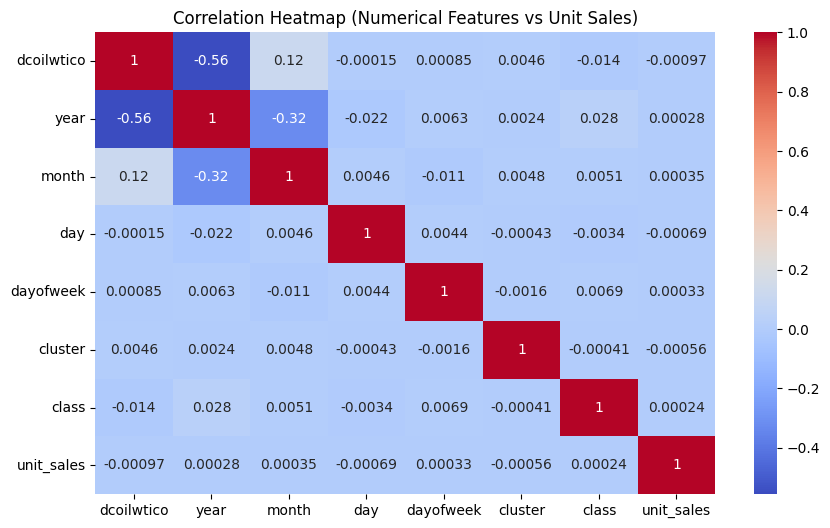

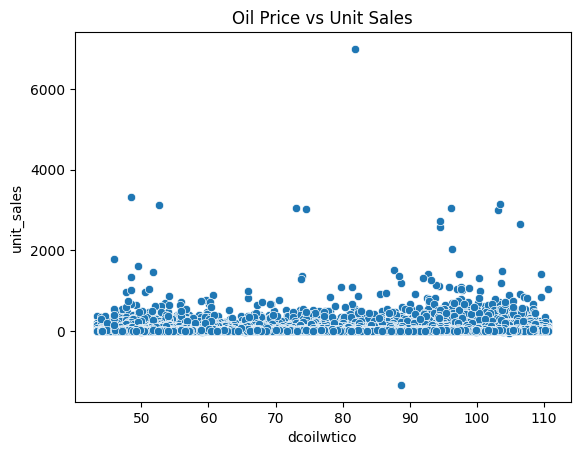

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical sütunları seç
num_cols = ["dcoilwtico", "year", "month", "day", "dayofweek", "cluster", "class"]
sample_df = X_train.copy()
sample_df["unit_sales"] = y_train
# Korrelasiya matrisi
plt.figure(figsize=(10,6))
sns.heatmap(sample_df[num_cols + ["unit_sales"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features vs Unit Sales)")
plt.show()

# Scatter plot (məsələn dcoilwtico ilə)
sns.scatterplot(x=sample_df["dcoilwtico"], y=y_train) # y_train = unit_sales
plt.title("Oil Price vs Unit Sales")
plt.show()


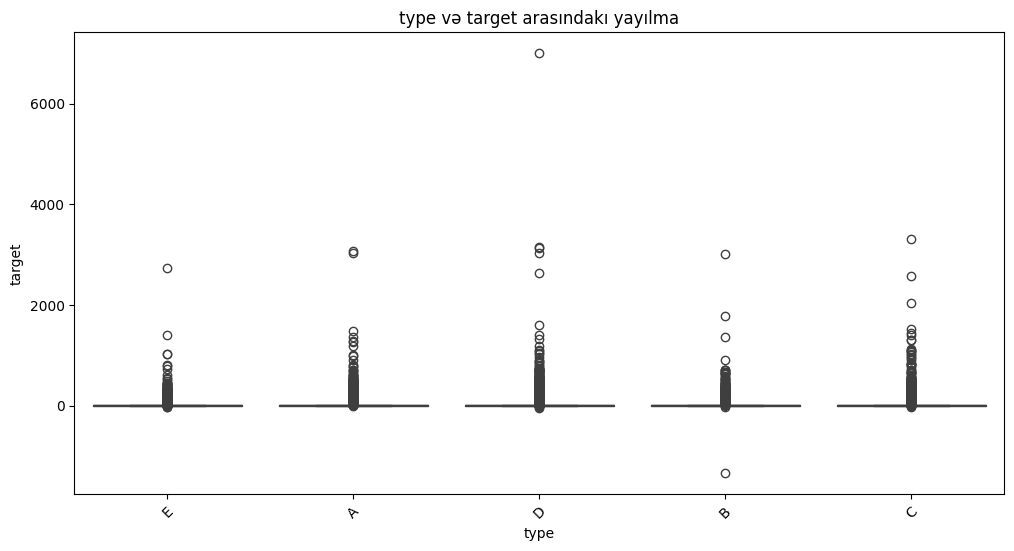

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = X_train.copy()
df["target"] = y_train

cat_col = "type"

plt.figure(figsize=(12,6))
sns.boxplot(x=cat_col, y="target", data=df)
plt.title(f"{cat_col} və target arasındakı yayılma")
plt.xticks(rotation=45)
plt.show()


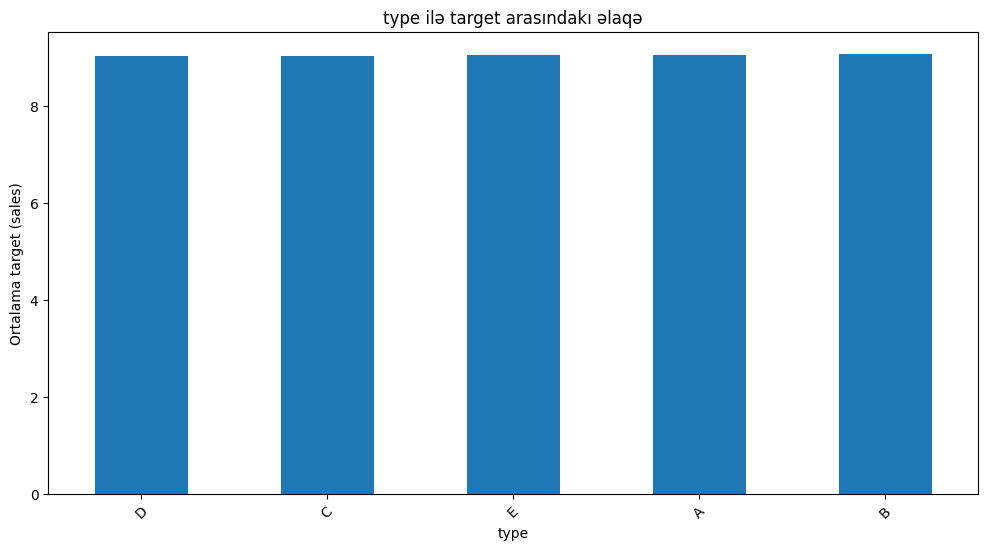

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# X_train və y_train birləşdir
df = X_train.copy()
df["target"] = y_train

# Categorical kolon seç
cat_col = "type"

# Hər bir kategoriya üçün target ortalamasını çıxar
mean_sales = df.groupby(cat_col)["target"].mean().sort_values()

# Bar plot çək
plt.figure(figsize=(12,6))
mean_sales.plot(kind="bar")
plt.title(f"{cat_col} ilə target arasındakı əlaqə")
plt.ylabel("Ortalama target (sales)")
plt.xlabel(cat_col)
plt.xticks(rotation=45)
plt.show()


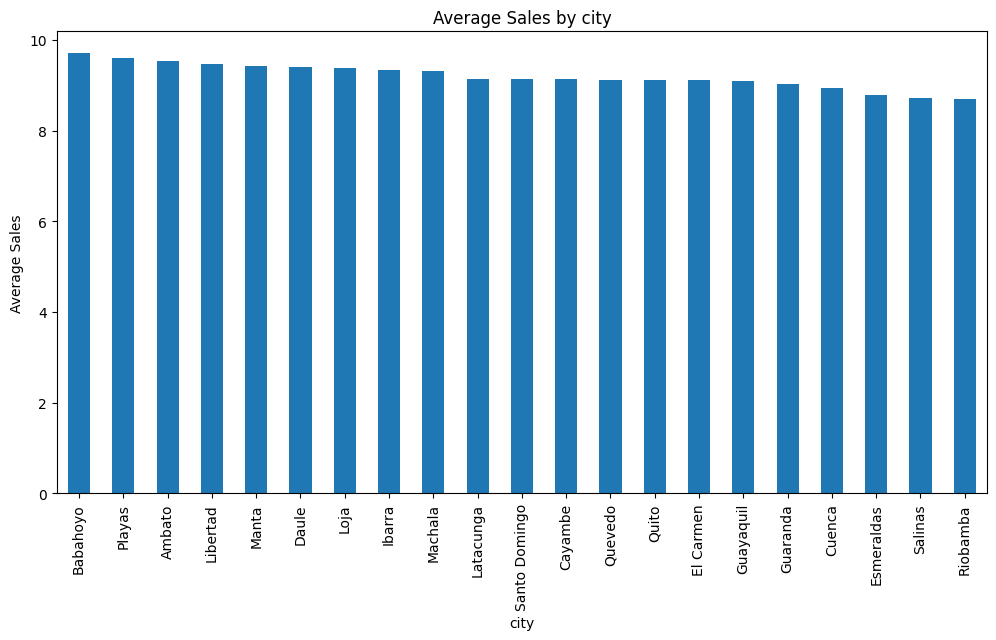

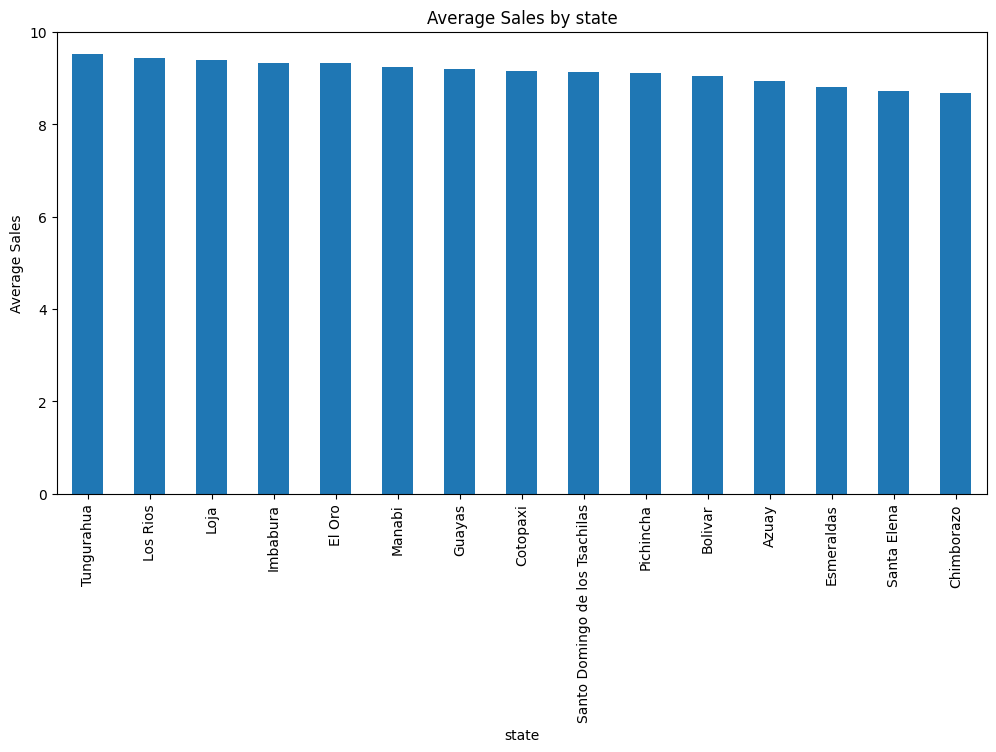

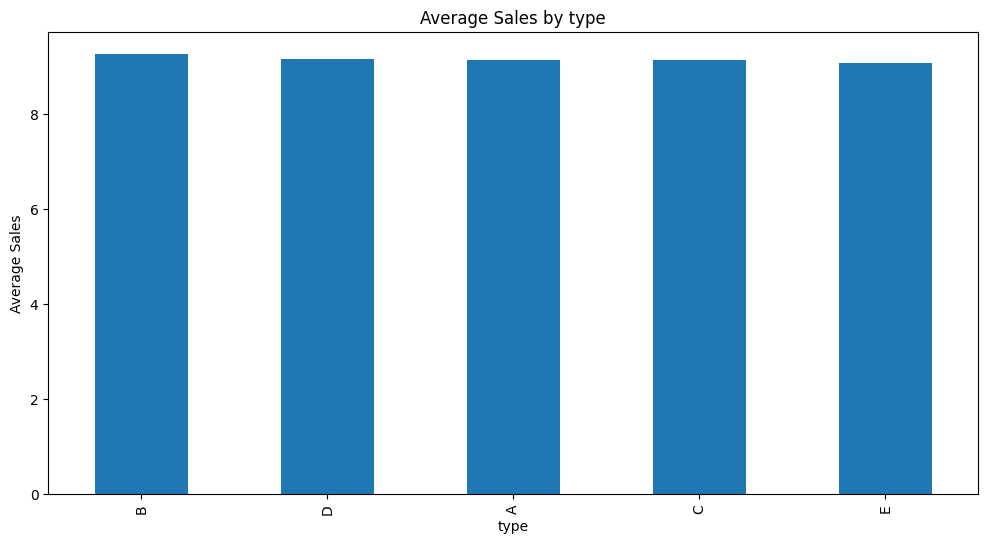

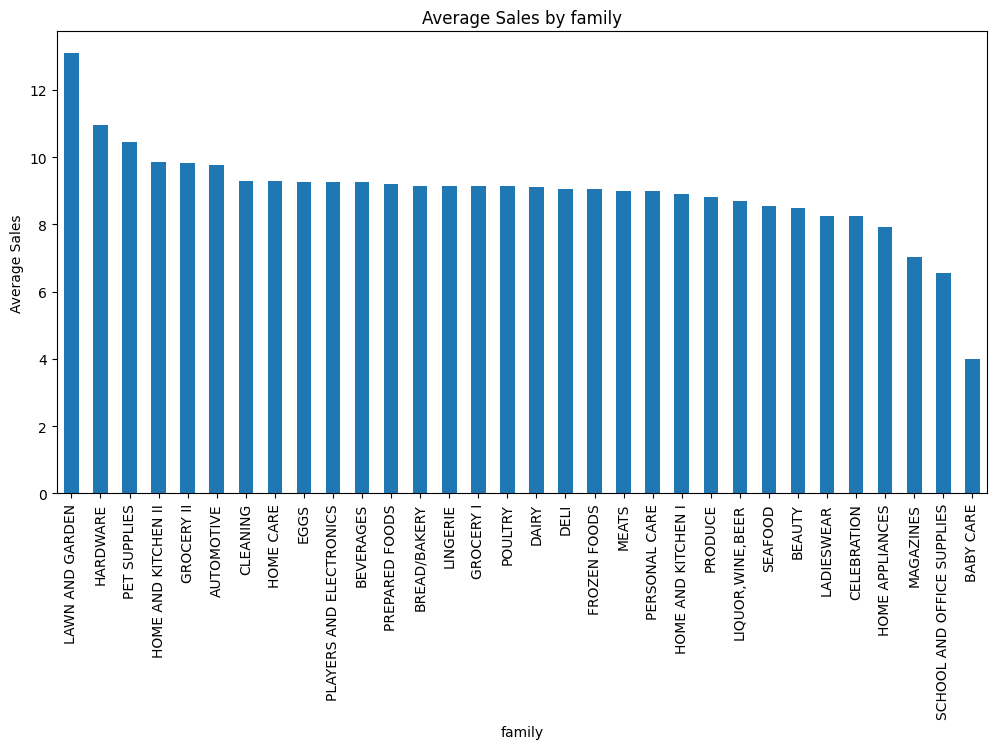

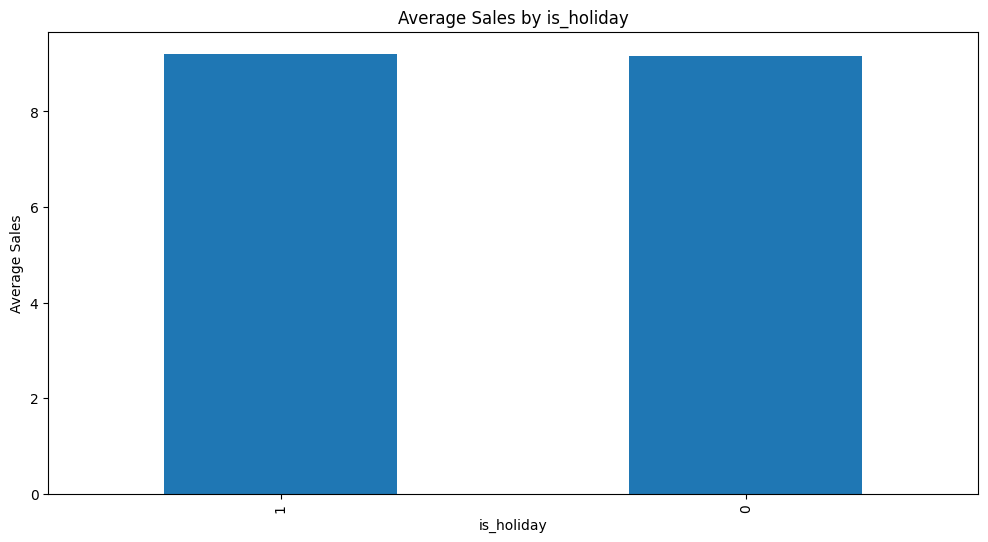

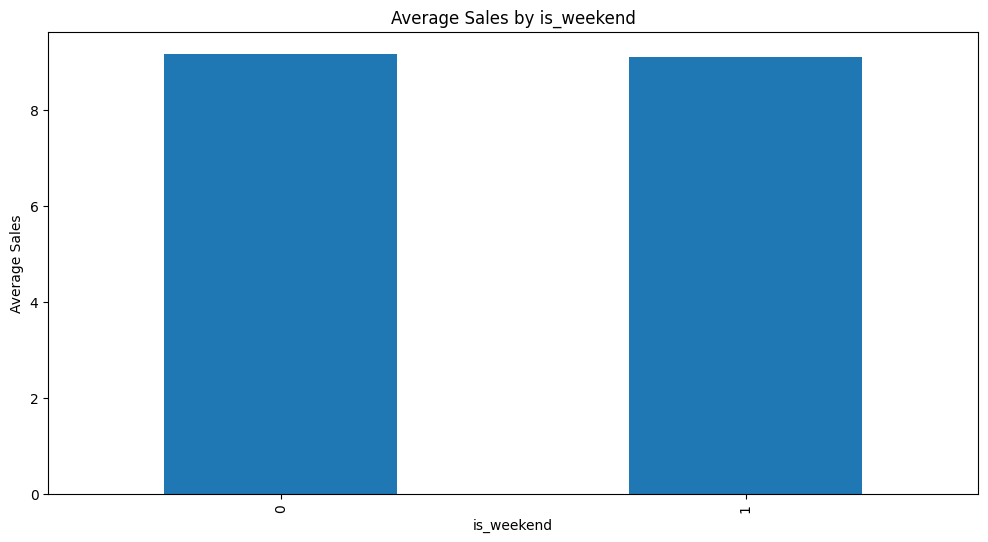

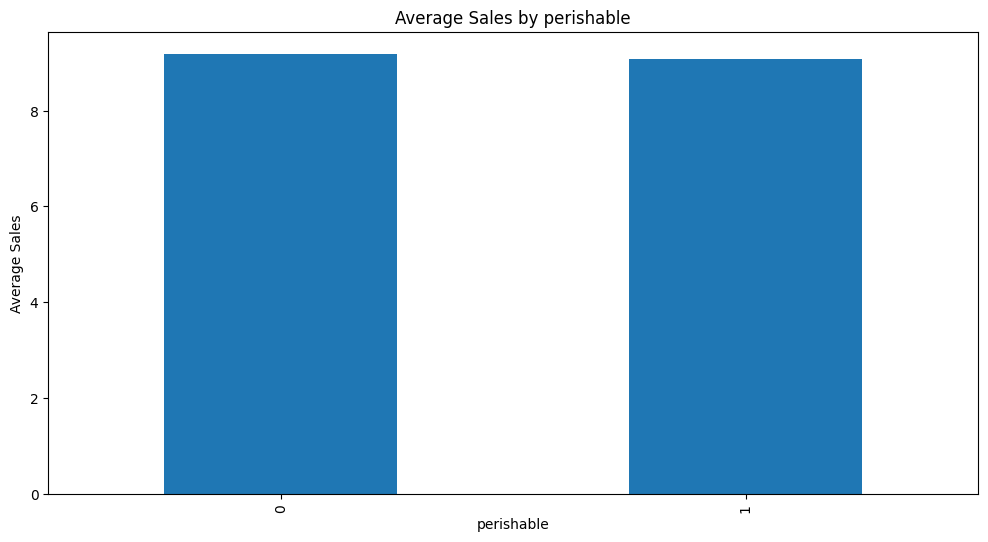

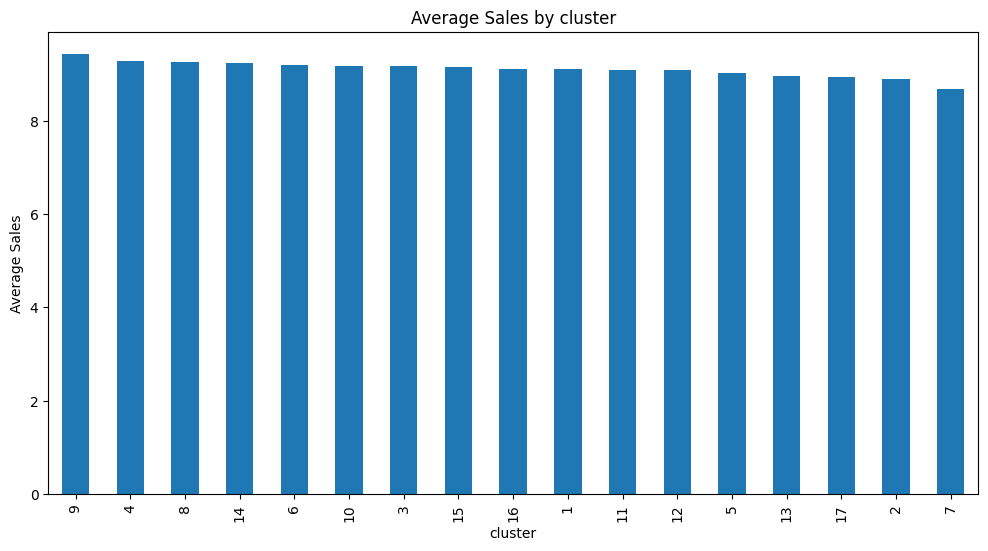

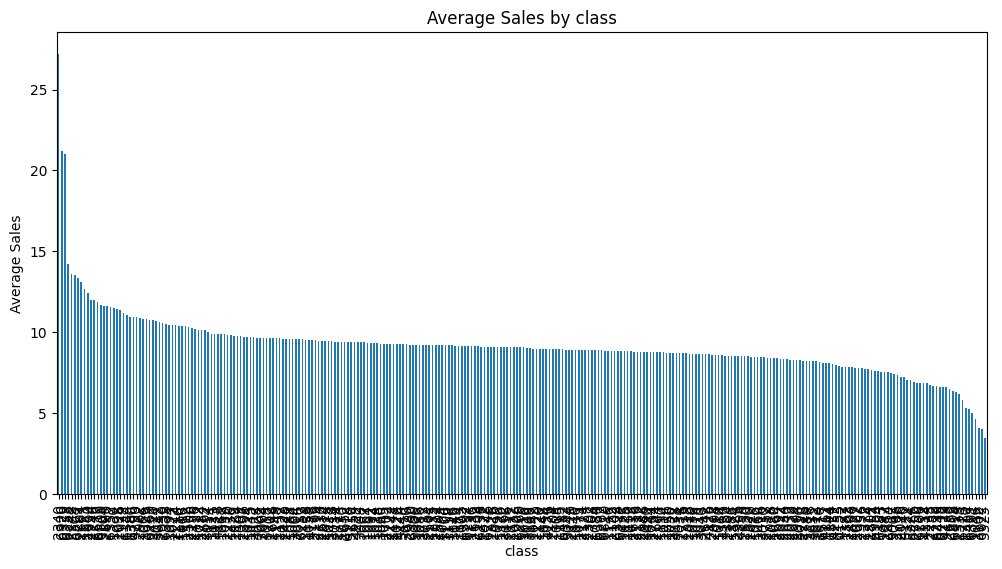

In [ ]:
import matplotlib.pyplot as plt

train_df = X_train.copy()
train_df["sales"] = y_train
train_df = train_df.sample(n=500_000, random_state=42)


cat_cols = ["city", "state", "type", "family", "is_holiday",
            "is_weekend", "perishable", "cluster", "class"]

for col in cat_cols:
    plt.figure(figsize=(12,6))
    (train_df.groupby(col)["sales"]
             .mean()
             .sort_values(ascending=False)
             .plot(kind="bar"))
    plt.xlabel(col)
    plt.ylabel("Average Sales")
    plt.title(f"Average Sales by {col}")
    plt.show()


In [ ]:
import pandas as pd

# High-cardinality üçün Frequency Encoding
def frequency_encoding(train, test, cols):
    for col in cols:
        freq = train[col].value_counts()
        train[col] = train[col].map(freq)
        test[col] = test[col].map(freq).fillna(0)
    return train, test

# One-Hot Encoding (low-cardinality üçün)
def one_hot_encoding(train, test, cols):
    train = pd.get_dummies(train, columns=cols, drop_first=True)
    test = pd.get_dummies(test, columns=cols, drop_first=True)
    # sütunları eyniləşdir
    test = test.reindex(columns=train.columns, fill_value=0)
    return train, test

# --- istifadə ---
high_card_cols = ["city", "state", "family"]
low_card_cols  = ["type", "is_holiday", "is_weekend", "perishable"]

X_train_enc, X_test_enc = frequency_encoding(X_train.copy(), X_test.copy(), high_card_cols)
X_train_enc, X_test_enc = one_hot_encoding(X_train_enc, X_test_enc, low_card_cols)

# Target-ları float-a çevir
y_train = y_train.astype(float)
y_test = y_test.astype(float)


In [ ]:
# -----------------------------
# Lazım olan kitabxanalar
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# Random sample seçirik (sürət üçün)
# -----------------------------
sample_size = 50000  # sample sayı
sample_indices = np.random.choice(X_train_enc.shape[0], size=sample_size, replace=False)
X_train_sample = X_train_enc.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

# -----------------------------
# Random Forest modelini qururuq
# -----------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,   # ağac sayı
    max_depth=12,       # ağac dərinliyi
    max_features="sqrt",# hər node-da istifadə olunacaq sütun sayı
    random_state=42,
    n_jobs=-1           # paralel işləmə
)

# -----------------------------
# Modeli fit edirik
# -----------------------------
rf_model.fit(X_train_sample, y_train_sample)

# -----------------------------
# Test data üzərində proqnoz
# -----------------------------
y_pred = rf_model.predict(X_test_enc)

# -----------------------------
# Nəticələri qiymətləndiririk
# -----------------------------
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 285.4694964258274
R^2 Score: 0.09597157365336662
